<h1> Problem 4

In [1]:
# Importing Libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,random_split

In [2]:
# Importing the data
daf = pd.read_csv("C:/Users/osave/Downloads/HW1_P5_weatherHistory.csv") #Importing the data
df = pd.DataFrame(daf,columns=["Temperature (C)","Apparent Temperature (C)","Humidity","Visibility (km)","Pressure (millibars)"])
df = df.drop(labels = "Pressure (millibars)",axis=1) #Drop Pressure since it does not really correlate
df.head()

,Temperature (C),Apparent Temperature (C),Humidity,Visibility (km)
0,9.472222,7.388889,0.89,15.8263
1,9.355556,7.227778,0.86,15.8263
2,9.377778,9.377778,0.89,14.9569
3,8.288889,5.944444,0.83,15.8263
4,8.755556,6.977778,0.83,15.8263


In [3]:
# Separate data into inputs and targets
targets = df['Temperature (C)'].values # Temperature as targets
inputs = df.drop(['Temperature (C)','Visibility (km)'],axis=1).values # Apparent Temperature and Humidity as inputs

In [4]:
# Sample Check
print(inputs)

[[ 7.38888889  0.89      ]
 [ 7.22777778  0.86      ]
 [ 9.37777778  0.89      ]
 ...
 [22.03888889  0.56      ]
 [21.52222222  0.6       ]
 [20.43888889  0.61      ]]


In [5]:
# Convert to Tensors
inputs = torch.tensor(inputs,dtype = torch.float32)
targets = torch.tensor(targets,dtype = torch.float32)

In [6]:
# Reshape to convert into a Dataset
targets = targets.reshape(targets.shape[-1],1)

In [7]:
# Make a dataset to split
dataset = TensorDataset(inputs,targets)

In [8]:
# Random Split into training and Testing dataset
train_ds,test_ds = random_split(dataset,[int(0.7*targets.shape[0]),targets.shape[0]-int(0.7*targets.shape[0])])

In [9]:
# Convert the split data into DataLoader for ease of running the code
train_dl = DataLoader(train_ds,batch_size=40,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=40)

In [111]:
# Develop the NN model
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(2,5),
                                    nn.ReLU(),
                                    nn.Linear(5,10),
                                    nn.ReLU(),
                                    nn.Linear(10,5),
                                    nn.ReLU(),
                                    nn.Linear(5,10),
                                    nn.ReLU(),
                                    nn.Linear(10,5),
                                    nn.ReLU(),
                                    nn.Linear(5,1))

    def forward(self,xb):
        return self.linear(xb)

    def training_step(self,batch):
        input_train,target_train = batch
        out = self(input_train)
        loss = F.mse_loss(out,target_train)
        return loss
    def val_step(self,batch):
        input_train,target_train = batch
        out = self(input_train)
        loss = F.mse_loss(out,target_train)
        return loss.detach()

model = NN()
model.train()

NN(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): ReLU()
    (10): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [112]:
# Use the SGD optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [113]:
# Run Model
train_history = [] # Save training loss
test_history = [] # Save testing loss
for epoch in range(50): # Run for 50 epochs
    train_losx = 0 #Total loss in 1 epoch training
    test_losx = 0 #Total loss in 1 epoch testing
    train_itr = 0 #Total iterations in 1 epoch
    test_itr = 0
    for batch in train_dl:
        optimizer.zero_grad()
        loss = model.training_step(batch) # Make training predictions
        train_losx +=loss.item() #Cumulate loss
        loss.backward()
        optimizer.step()
        train_itr +=1
    for batch in test_dl:
        result = model.val_step(batch)
        test_losx +=result.item()
        test_itr +=1
    print(train_losx,test_losx)
    train_history.append(train_losx/train_itr) # Save loss per epoch
    test_history.append(test_losx/test_itr)


6807.331758469343 765.8840155005455
1685.741145849228 682.870848596096
1679.538864120841 667.8328067809343
1668.4992050975561 712.7685706019402
1683.1617300063372 675.6680687963963
1664.5700585842133 674.6242793798447
1635.425551995635 706.5336606949568
1658.266066968441 666.218822285533
1646.442933358252 673.4136159718037
1652.0803187042475 674.1896588206291
1637.0175365805626 709.6716910898685
1634.5566195100546 662.7910662442446
1648.279795050621 684.6755148768425
1625.571840941906 671.3507574945688
1646.1838701441884 746.5786723047495
1645.6593516469002 707.6527072191238
1645.1170745193958 679.3435448110104
1625.7232857644558 711.5426275283098
1632.61804690212 674.6211765855551
1632.0763148218393 687.262096658349
1642.2875440120697 696.7083795815706
1623.6132339537144 742.540795609355
1630.6410759091377 669.5181472301483
1639.4482931792736 658.3266127109528
1636.0895539820194 686.0413470864296
1617.7345290631056 715.5821704864502
1649.865972980857 699.125979244709
1623.227036640048

Text(0, 0.5, 'Loss')

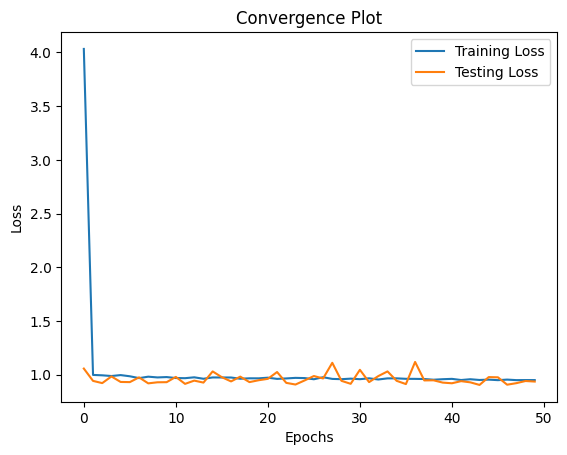

In [114]:
# Plot training vs testing loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_history)
plt.plot(test_history)
plt.legend(['Training Loss','Testing Loss'])
plt.title('Convergence Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [115]:
# Make all predictions on the trained data
predictions = model.forward(inputs)

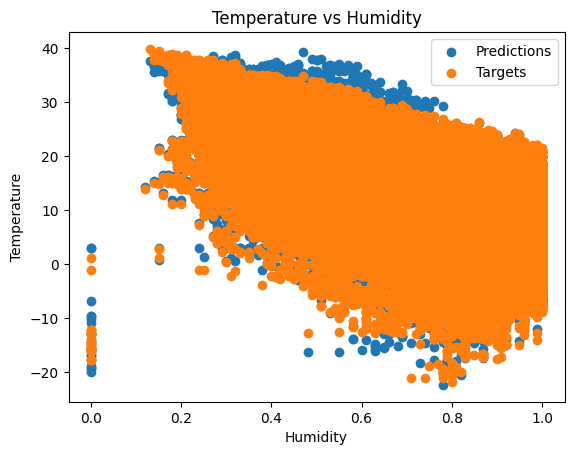

In [116]:
# Plot figures
plt.figure()
plt.scatter(inputs.data[:,1].detach(),predictions.data[:].detach())
plt.scatter(inputs.data[:,1].detach(),targets.data[:].detach())
plt.xlabel('Humidity')
plt.ylabel('Temperature')
plt.title('Temperature vs Humidity')
plt.legend(['Predictions','Targets'])

<h1> Problem 5

In [117]:
# Import Libraries
import os
import numpy as np

In [118]:
# Get current work directory
os.getcwd()

'C:\\Users\\osave\\PycharmProjects\\MAE551'

In [119]:
# Set directory to images path
path = 'C:\\Users\\osave\\Downloads\\dogs-vs-cats'
os.chdir(path)

In [120]:
# Check again
os.getcwd()

'C:\\Users\\osave\\Downloads\\dogs-vs-cats'

In [121]:
# Set train and test directory
train_dir = '\\train'
test_dir = '\\test1'

In [122]:
# Check all images in train directory
os.listdir(path+train_dir)

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg',
 'cat.10008.jpg',
 'cat.10009.jpg',
 'cat.1001.jpg',
 'cat.10010.jpg',
 'cat.10011.jpg',
 'cat.10012.jpg',
 'cat.10013.jpg',
 'cat.10014.jpg',
 'cat.10015.jpg',
 'cat.10016.jpg',
 'cat.10017.jpg',
 'cat.10018.jpg',
 'cat.10019.jpg',
 'cat.1002.jpg',
 'cat.10020.jpg',
 'cat.10021.jpg',
 'cat.10022.jpg',
 'cat.10023.jpg',
 'cat.10024.jpg',
 'cat.10025.jpg',
 'cat.10026.jpg',
 'cat.10027.jpg',
 'cat.10028.jpg',
 'cat.10029.jpg',
 'cat.1003.jpg',
 'cat.10030.jpg',
 'cat.10031.jpg',
 'cat.10032.jpg',
 'cat.10033.jpg',
 'cat.10034.jpg',
 'cat.10035.jpg',
 'cat.10036.jpg',
 'cat.10037.jpg',
 'cat.10038.jpg',
 'cat.10039.jpg',
 'cat.1004.jpg',
 'cat.10040.jpg',
 'cat.10041.jpg',
 'cat.10042.jpg',
 'cat.10043.jpg',
 'cat.10044.jpg',
 'cat.10045.jpg',
 'cat.10046.jpg',
 'cat.1004

In [123]:
# Import glob for saving train list labels
import glob

In [124]:
# Generate train list of either cats or dogs
trainlist = glob.glob(os.path.join(path+train_dir,'*.jpg'))

In [125]:
# Random check train list
(trainlist[1000].split('\\')[-1].split('.')[0])

'cat'

In [199]:
# Import PIL for image support
from PIL import Image
import torchvision.transforms.functional as TF
import torch.nn.functional as F

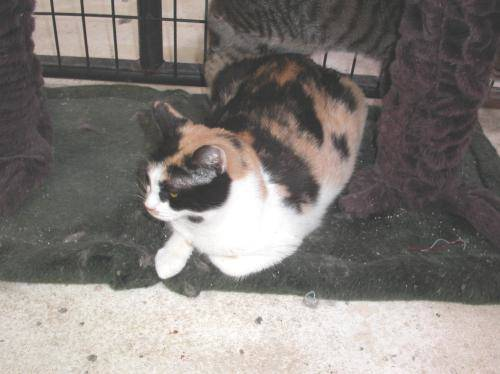

In [151]:
# Randomly check an image
Image.open(trainlist[1000])

In [129]:
# Use torchvision support for applying transforms
from torchvision import transforms

In [130]:
transformer = transforms.Compose([transforms.Resize([128,128]),
                                  transforms.Grayscale(),
                                  transforms.RandomHorizontalFlip(p = 0.8),
                                  transforms.RandomVerticalFlip(p = 0.6),
                                  transforms.ToTensor()])

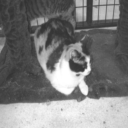

In [160]:
transforms.ToPILImage()(transformer(Image.open(trainlist[1000])))

In [131]:
# Create a dataset class
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform):
        self.filelist = file_list
        self.transformer = transform

    def __len__(self):
        return len(self.filelist)
    def __getitem__(self, item):
        img_path = self.filelist[item]
        img = Image.open(img_path)
        im_trans = self.transformer(img)
        label = (img_path.split('\\')[-1].split('.')[0])
        if label == 'cat':
            label = 1
        else:
            label = 0
        return im_trans,label

In [132]:
# Random split train and test data
train_ds,test_ds = random_split(trainlist,[int(0.7*len(trainlist)),int(0.3*len(trainlist))])

In [133]:
# Transform training images using transformer
train_data = dataset(train_ds,transformer)

In [134]:
# Transform testing images using transformer
test_data = dataset(test_ds,transformer)

In [135]:
check = transforms.ToPILImage()

In [136]:
# Convert data into data loader and separate into batches
train_loader = DataLoader(dataset=train_data,batch_size=50,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=50)

In [137]:
len(test_loader)

150

In [307]:
# CNN Class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1,16,kernel_size=2,padding=0,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(16,32,kernel_size=2,padding=0,stride=2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(32,64,kernel_size=2,padding=0,stride=2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(nn.Linear(256,50),
                                    nn.Dropout(p = 0.4),
                                    nn.Linear(50,25),
                                    nn.ReLU(),
                                    nn.Linear(25,2),
                                    nn.ReLU())
    def forward(self,xin):
        out = self.layer1(xin)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.layer4(out)
        return out


In [308]:
model = CNN()
model.train()


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=256, out_features=50, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=50, out_features

In [309]:
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [310]:
epochs = 20

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    with torch.no_grad():
        epoch_test_accuracy=0
        epoch_test_loss =0
        for data, label in test_loader:
            test_output = model(data)
            test_loss = criterion(test_output,label)
            acc = ((test_output.argmax(dim=1) == label).float().mean())
            epoch_test_accuracy += acc/ len(test_loader)
            epoch_test_loss += test_loss/ len(test_loader)
    print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch+1, epoch_test_accuracy,epoch_test_loss))

Epoch : 1, train accuracy : 0.4992574453353882, train loss : 0.6796220541000366
Epoch : 1, test_accuracy : 0.4999997913837433, test_loss : 0.6548871994018555
Epoch : 2, train accuracy : 0.5419427156448364, train loss : 0.6390128135681152
Epoch : 2, test_accuracy : 0.662400484085083, test_loss : 0.614348828792572
Epoch : 3, train accuracy : 0.6783426403999329, train loss : 0.5942864418029785
Epoch : 3, test_accuracy : 0.6961338520050049, test_loss : 0.5774064660072327
Epoch : 4, train accuracy : 0.6967996954917908, train loss : 0.5733035206794739
Epoch : 4, test_accuracy : 0.6880004405975342, test_loss : 0.5821169018745422
Epoch : 5, train accuracy : 0.7126851081848145, train loss : 0.5559999346733093
Epoch : 5, test_accuracy : 0.7188004851341248, test_loss : 0.5532012581825256
Epoch : 6, train accuracy : 0.7231428623199463, train loss : 0.544596254825592
Epoch : 6, test_accuracy : 0.7220004200935364, test_loss : 0.5539179444313049
Epoch : 7, train accuracy : 0.732685387134552, train lo

In [229]:
acc = 0
for i in range(len(test_loader.dataset)):
    check = F.softmax(model(train_loader.dataset[i][0].reshape(1,1,128,128)),dim=1)
    check[0]
    if check[0][0].detach()>check[0][1].detach():
        check_lab = 1
    else:
        check_lab = 0
    if train_loader.dataset[i][1]==check_lab:
        acc +=1
print('Total Correct Guess {}'.format(acc/len(test_loader.dataset)))

KeyboardInterrupt: 

<h1> Problem 6

In [311]:
# Importing the data
daf = pd.read_csv("C:/Users/osave/Downloads/HW2_P6_international-airline-passengers.csv")

In [312]:
# Converting the data into Pandas Dataframe
df = pd.DataFrame(daf)

In [313]:
# Quick visualization of the data
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [500]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Airline Passengers vs Period')

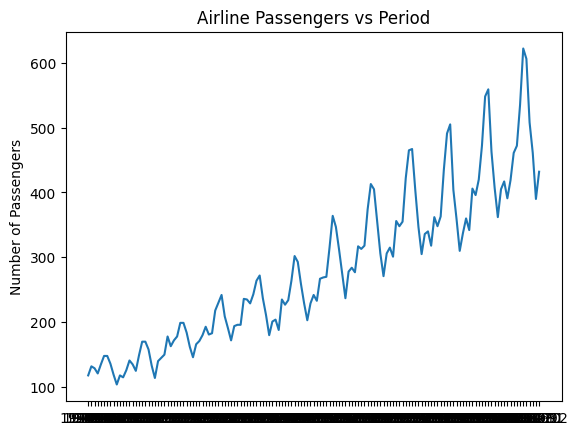

In [314]:
#Visualizing the data
plt.figure()
plt.plot(df.iloc[1:-1,0].values,df.iloc[1:-1,1].values)
plt.ylabel('Number of Passengers')
plt.title('Airline Passengers vs Period')

In [315]:
# Scaling the data for better training
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform((df.iloc[0:-1,1]).values.reshape(-1,1))

In [317]:
# Convert data into tensor and random split
data_tensor = torch.tensor(scaled_data,dtype=torch.float32)
train_ds,test_ds = [data_tensor[0:int(0.84*len(data_tensor))],data_tensor[0:int(len(data_tensor)-0.84*len(data_tensor))]];

In [318]:
# Using sequence class to make inputs and targets
from torch.autograd import Variable
def sequence(data, window):
    L = len(data)
    seq = []
    for i in range(L-window):
        input = data[i:i+window]
        out = data[i+window:i+window+1]
        seq.append((input,out))
    return seq

In [349]:
train_sequence = sequence(train_ds,12)
test_sequence = sequence(test_ds,12)

In [409]:
# Create RNN Class
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size)
        self.linear = nn.Sequential(nn.Linear(hidden_size,hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size,output_size))
        self.hidden = (torch.zeros(1,1,hidden_size))

    def forward(self,input_seq):
        out,_ = self.rnn(input_seq.view(len(input_seq),1,-1),self.hidden)
        outx = self.linear(out.view(len(input_seq),-1))
        return outx[-1]



In [410]:
# Initiate RNN
model = RNN(1,10,1)

In [411]:
# Set training mode
model.train()

RNN(
  (rnn): RNN(1, 10)
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [412]:
# Set Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.000001)
criterion = nn.MSELoss()

In [413]:
# Run epochs
epochs = 2000
loss_history_train = []
loss_history_test = []
for i in range(epochs):
    itr = 0
    epoch_loss = 0
    for in_seq,out_seq in train_sequence:
        y_pred = model(in_seq)
        optimizer.zero_grad()
        loss = criterion(y_pred,out_seq.reshape(1))
        loss.backward()
        optimizer.step()
        epoch_loss+=loss
    loss_history_train.append(loss.item())
    if i%100==0:
        print(loss.item())
    with torch.no_grad():
        for in_seq,out_seq in test_sequence:
            y_pred = model(in_seq)
            loss = criterion(y_pred,out_seq.reshape(1))
        loss_history_test.append(loss.item())

0.41051846742630005
0.3475821614265442
0.2889634966850281
0.24179309606552124
0.20058965682983398
0.1619299203157425
0.12686267495155334
0.09671105444431305
0.0724126473069191
0.05442434176802635
0.042388372123241425
0.034654878079891205
0.029763977974653244
0.026771318167448044
0.02484193630516529
0.023576440289616585
0.022815031930804253
0.02230539172887802
0.02194211632013321
0.02168894186615944


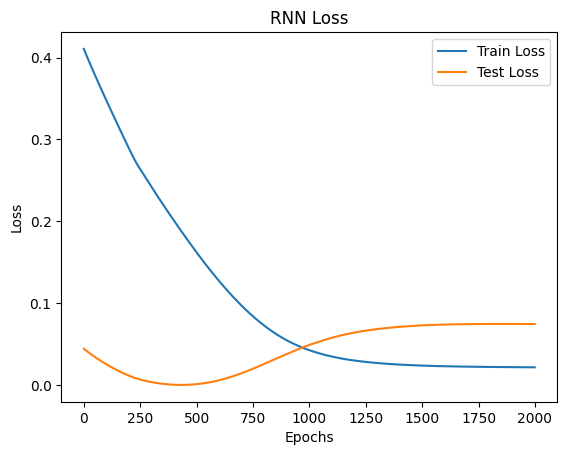

In [414]:
# Plot loss over epochs
plt.figure()
plt.plot(loss_history_train)
plt.plot(loss_history_test)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('RNN Loss')
plt.legend(['Train Loss','Test Loss'])

In [404]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size,hidden_size=hidden_size)
        self.linear = nn.Sequential(nn.Linear(hidden_size,hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size,output_size))
        self.hidden = (torch.zeros(1,1,hidden_size))

    def forward(self,input_seq):
        out,_ = self.rnn(input_seq.view(len(input_seq),1,-1),(self.hidden,self.hidden))
        outx = self.linear(out.view(len(input_seq),-1))
        return outx[-1]


In [405]:
model = LSTM(1,10,1)
model.train()

LSTM(
  (rnn): LSTM(1, 10)
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [406]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.000001)
criterion = nn.MSELoss()

In [407]:
epochs = 2000
loss_history_train = []
loss_history_test = []
for i in range(epochs):
    itr = 0
    epoch_loss = 0
    for in_seq,out_seq in train_sequence:
        y_pred = model(in_seq)
        optimizer.zero_grad()
        loss = criterion(y_pred,out_seq.reshape(1))
        loss.backward()
        optimizer.step()
        itr+=1
        epoch_loss+=loss
    loss_history_train.append(loss.item())
    if i%100==0:
        print(loss.item())
    with torch.no_grad():
        for in_seq,out_seq in test_sequence:
            y_pred = model(in_seq)
            loss = criterion(y_pred,out_seq.reshape(1))
        loss_history_test.append(loss.item())

0.035257384181022644
0.03129683807492256
0.028396641835570335
0.02619820274412632
0.02449990250170231
0.02316555194556713
0.022092098370194435
0.021203193813562393
0.020442107692360878
0.01976466365158558
0.019136693328619003
0.01852964237332344
0.017924712970852852
0.01730278693139553
0.016706276684999466
0.016042519360780716
0.015330368652939796
0.014589555561542511
0.013725710101425648
0.012733005918562412


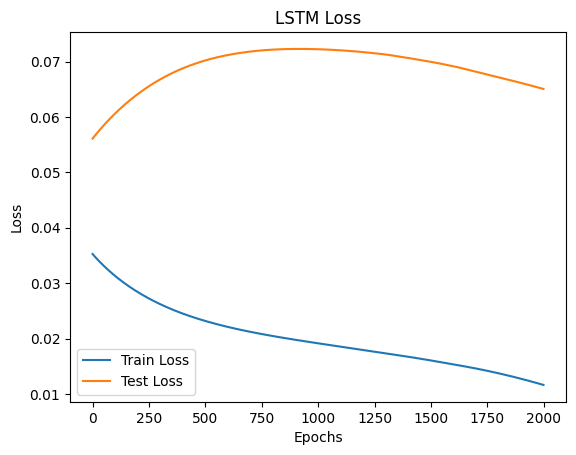

In [408]:
# Plot loss over epochs
plt.figure()
plt.plot(loss_history_train)
plt.plot(loss_history_test)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('LSTM Loss')
plt.legend(['Train Loss','Test Loss'])